In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium
%pip install html2image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic


#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

## Energy Consumptions🔌

In [4]:
#cspell:disable


project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=(-33.366067,-71.668636),
        name='Cesfam Algarrobo',
        address='Calle Carabineros de Chille Nro 2350',
        city='Algarrobo'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':8/100,
        'consumption':[
            (16200,"21-10-2023",1502597),
            (14200,"21-11-2023",1317093),
            (13600,"20-12-2023",1261439),
            (14600,"19-01-2024",1354192),
            (12800,"21-02-2024",1187238),
            (15400,"21-03-2024",1428395),
            (18400,"23-04-2024",1706656),
            (17000,"23-05-2024",1557885),
            (21600,"19-06-2024",2158857), 
            (14800,"22-07-2024",1479216), 
            (11800,"22-08-2024",1179375), 
            (10200,"23-09-2024",1099295),
            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.366067&longitude=-71.668636&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.01 
set $1 UTM............ on USD$68.21 
set $1 Euro........... on USD$1.06 
set $1 Pound.......... on USD$1.27 
set $1 Real........... on USD$0.17 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable
from libs.repository import repo
#clean previous load
project.components = {}
from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módular FV 01',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=30,
                cost=None,
                orientation=Orientation(15,22),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    Photovoltaic(project.weather,'Módular FV 02',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=14,
                cost=None,
                orientation=Orientation(15,22),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    Photovoltaic(project.weather,'Módulas FV 03',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=6,
                cost=None,
                orientation=Orientation(15,22),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    repo['inverter']['Deye 30kW'],#inverter
    Component('Controlador de Carga',
                model='MPPT Victron SmartSolar',
                specification='To 100amp 12/48V output',
                cost_per_unit=Cost(980,Currency.EUR),
                reference='https://solarbex.com/comprar/regulador-carga-smartsolar-mppt-150-100/',
                quantity=2
                ),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Battery('almacenamiento',
                model='MP GEL12-250',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                cost_per_unit=Cost(305990,Currency.CLP),
                volt=12,
                charge=250,
                demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
                hours_autonomy=4,
                use_regime='24/7',
                )
    )

#gen number of panels
pv_quantity = sum(list(map(lambda it:it.quantity,project.components['generación'])))

#works
project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=pv_quantity*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=pv_quantity*4
            )
)


inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP


# Write Document 📒


In [6]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [7]:
from models.plotter import toTable
toTable(project,PATH)

### Generate Context->Doc📄✍️

In [8]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [9]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


## Insert Plots 📊

In [10]:
bucket_df = project.bucket_list(Currency.CLP)['bucket']
#cspell: disable
bucket_df[['description','details','quantity','cost_after_tax']]\
    .rename(columns={
                        'description':'descripción',
                        'details':'técnico',
                        'quantity':'cantidad',
                        'cost_after_tax':'costo bruto'
                    }).to_markdown(index=False,floatfmt=',.0f')

'| descripción                | técnico                  |   cantidad |   costo bruto |\n|:---------------------------|:-------------------------|-----------:|--------------:|\n| Módular FV 01              | Solar Panel PV 650W 48V  |         30 |     8,781,843 |\n| Módular FV 02              | Solar Panel PV 650W 48V  |         14 |     4,098,193 |\n| Módulas FV 03              | Solar Panel PV 650W 48V  |          6 |     1,756,369 |\n| Inversor Híbrido Trifásico | Ongrid Hibrido 30kW 380v |          1 |     6,207,713 |\n| Controlador de Carga       | To 100amp 12/48V output  |          2 |     2,029,544 |\n| medidor bidireccional      | Trifasico                |          1 |       365,318 |\n| almacenamiento             | Battery 12V 250Ah        |         28 |    10,195,587 |\n| instalación eléctrica      | H/P eléctrico            |        250 |     9,527,188 |\n| estructura de soporte      | elementos fijación       |        200 |     3,177,300 |'

c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

plot_done


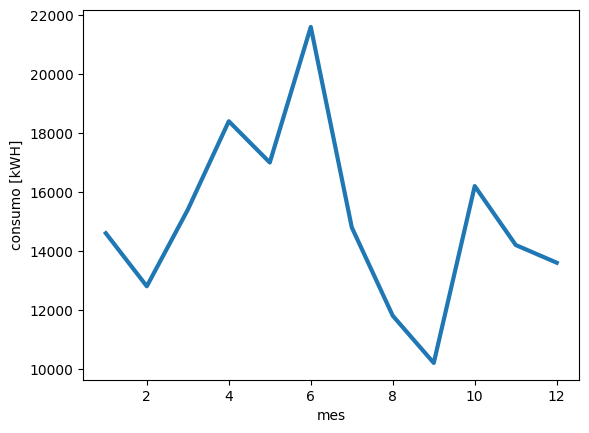

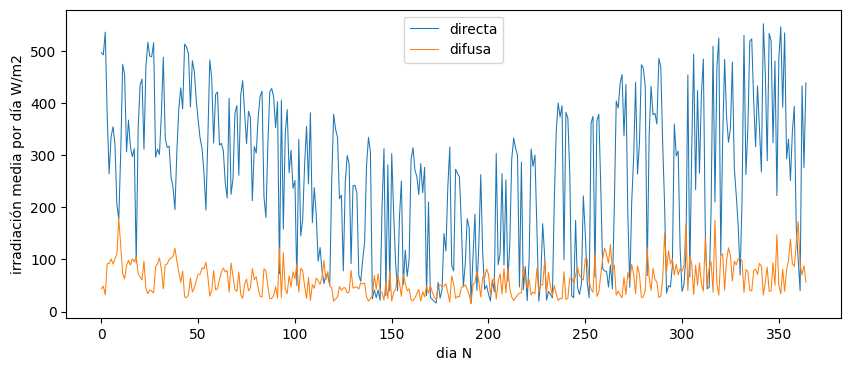

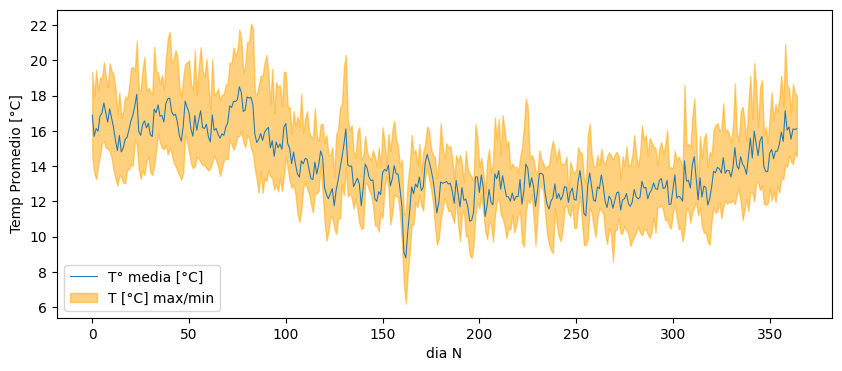

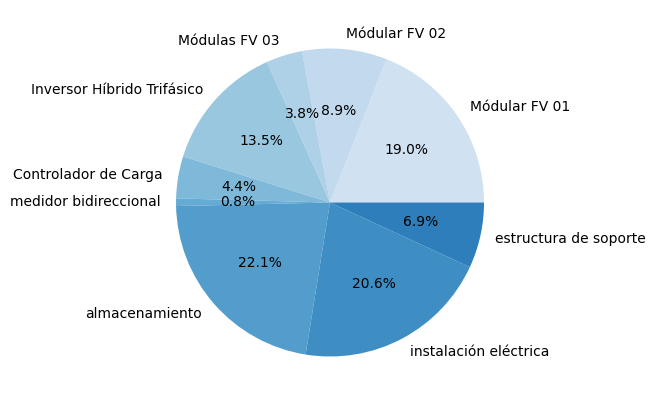

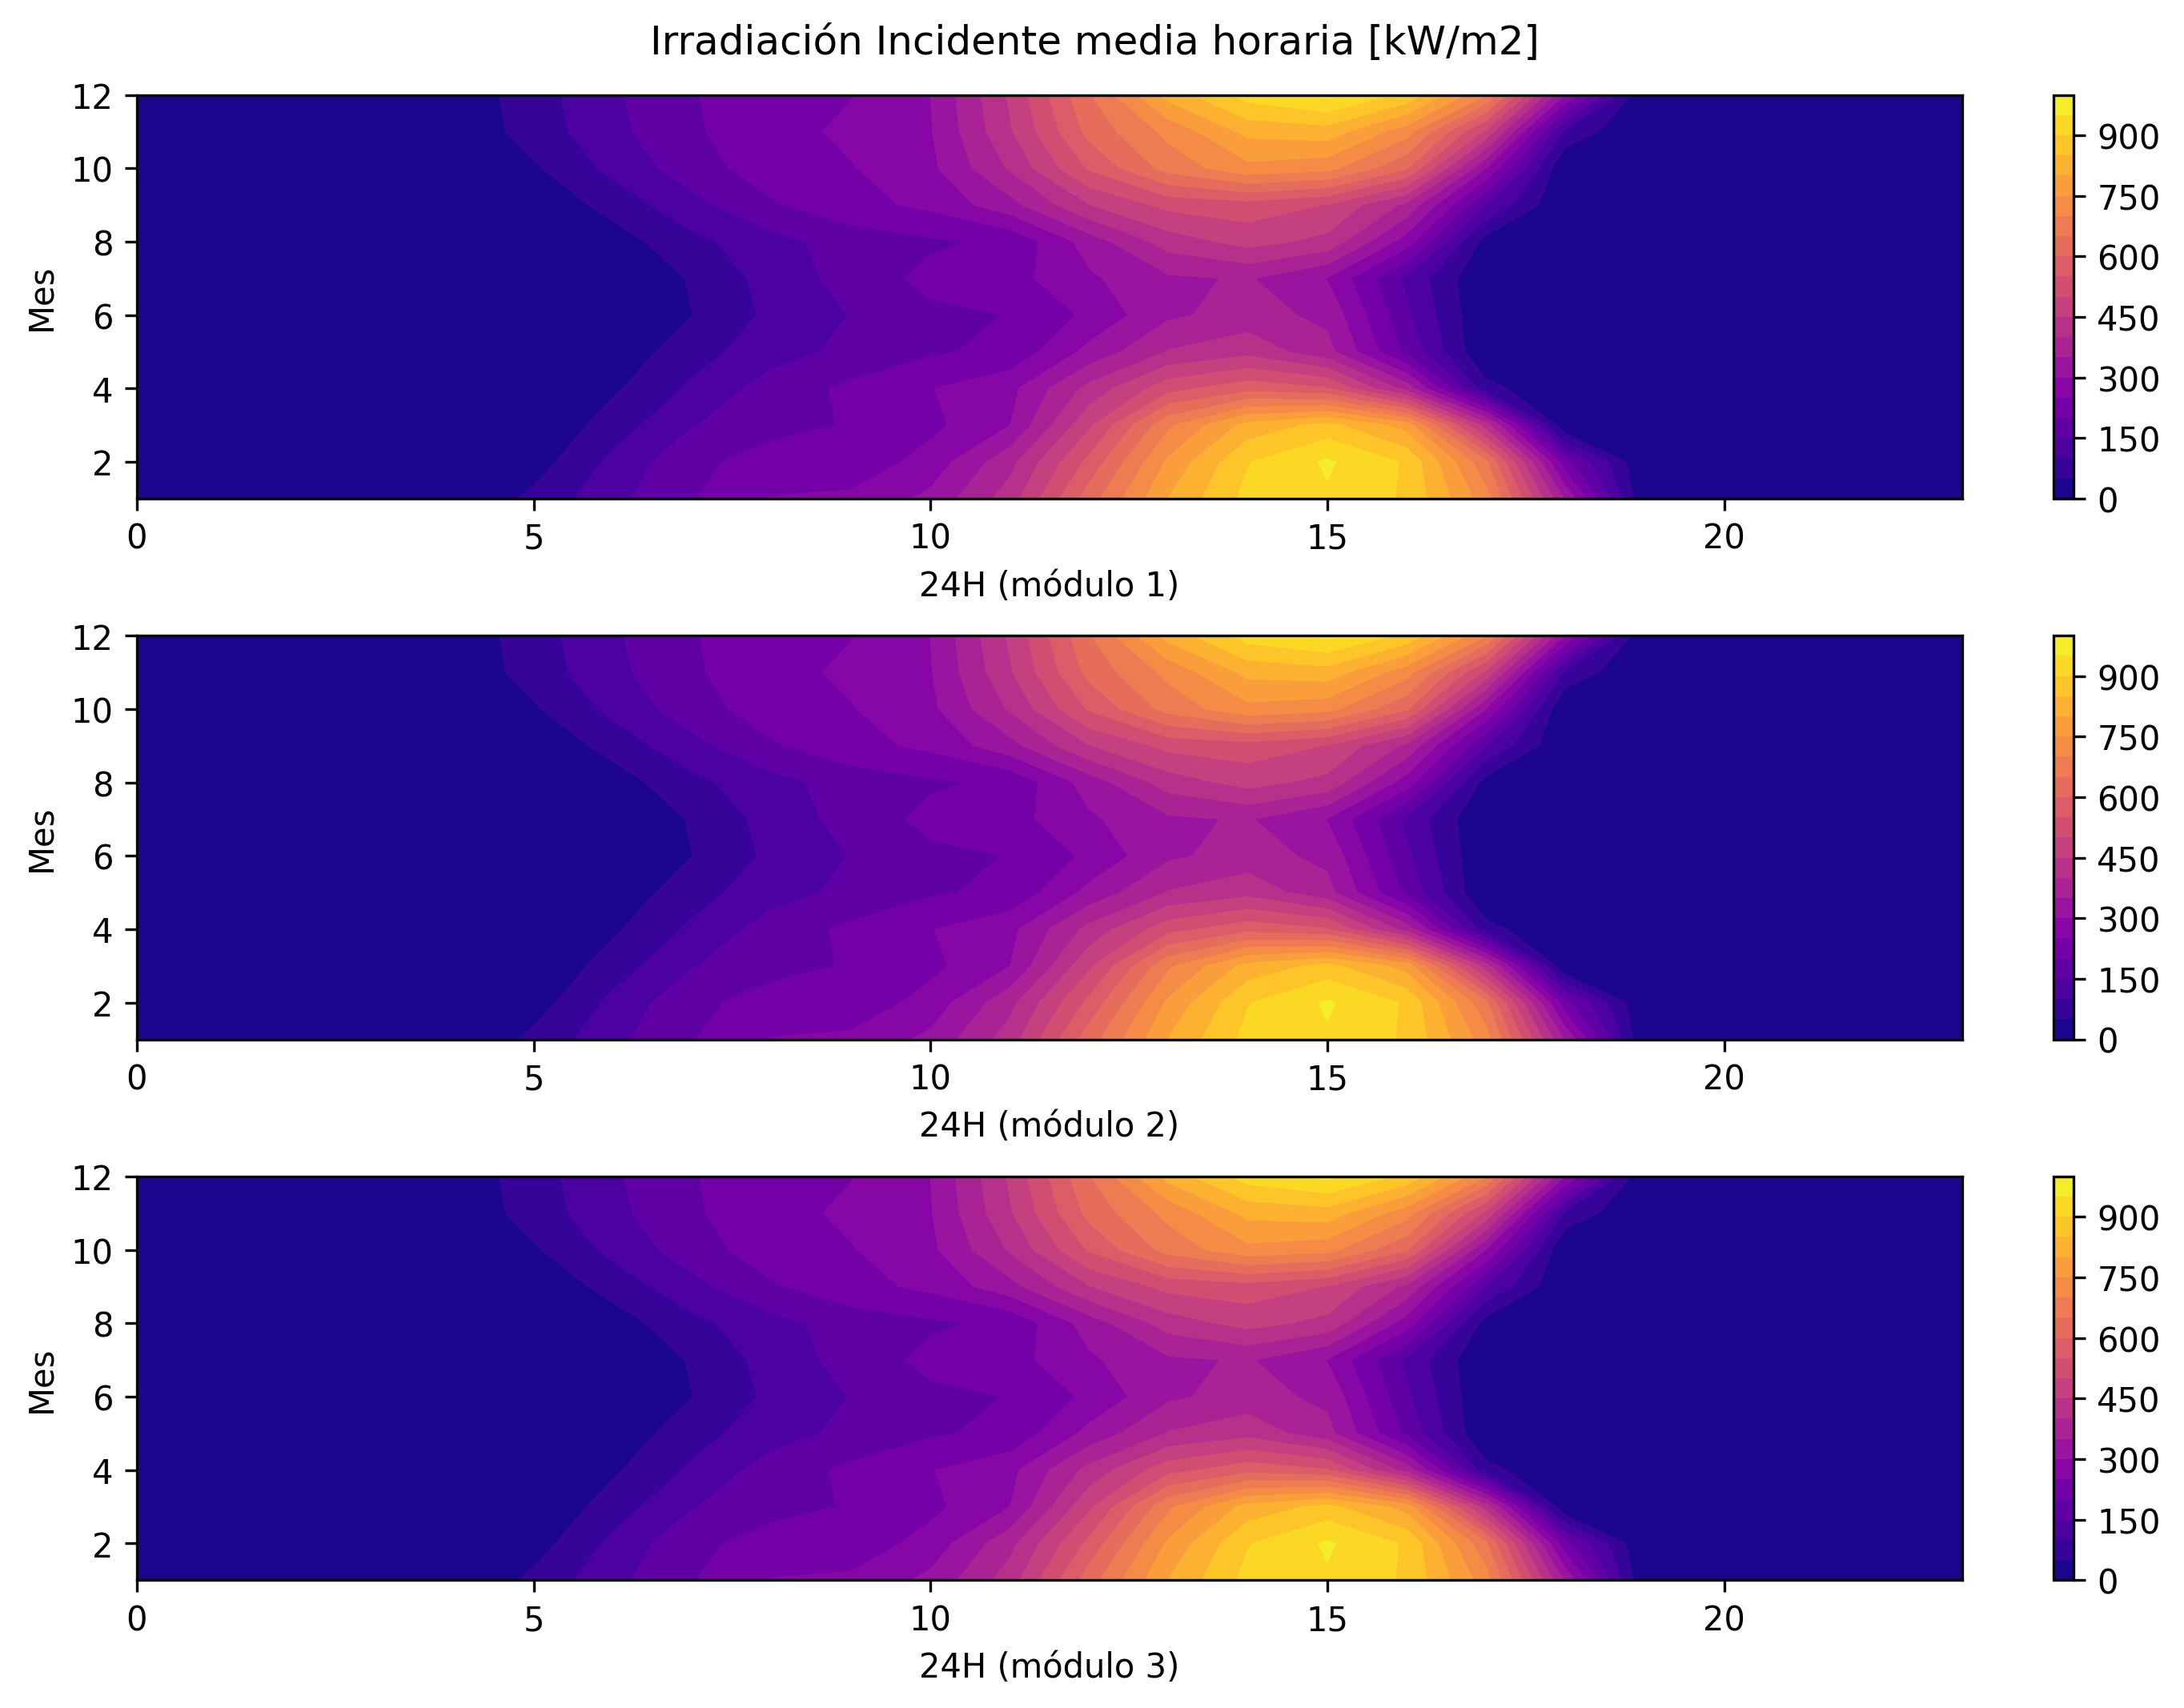

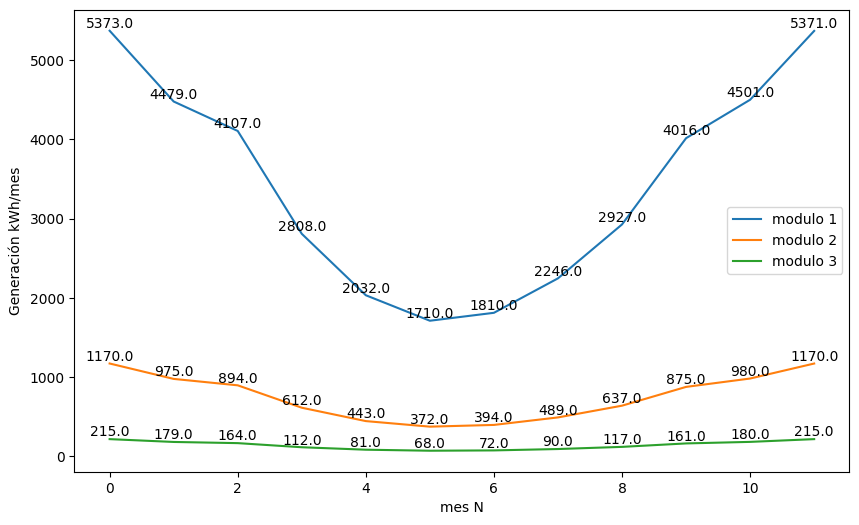

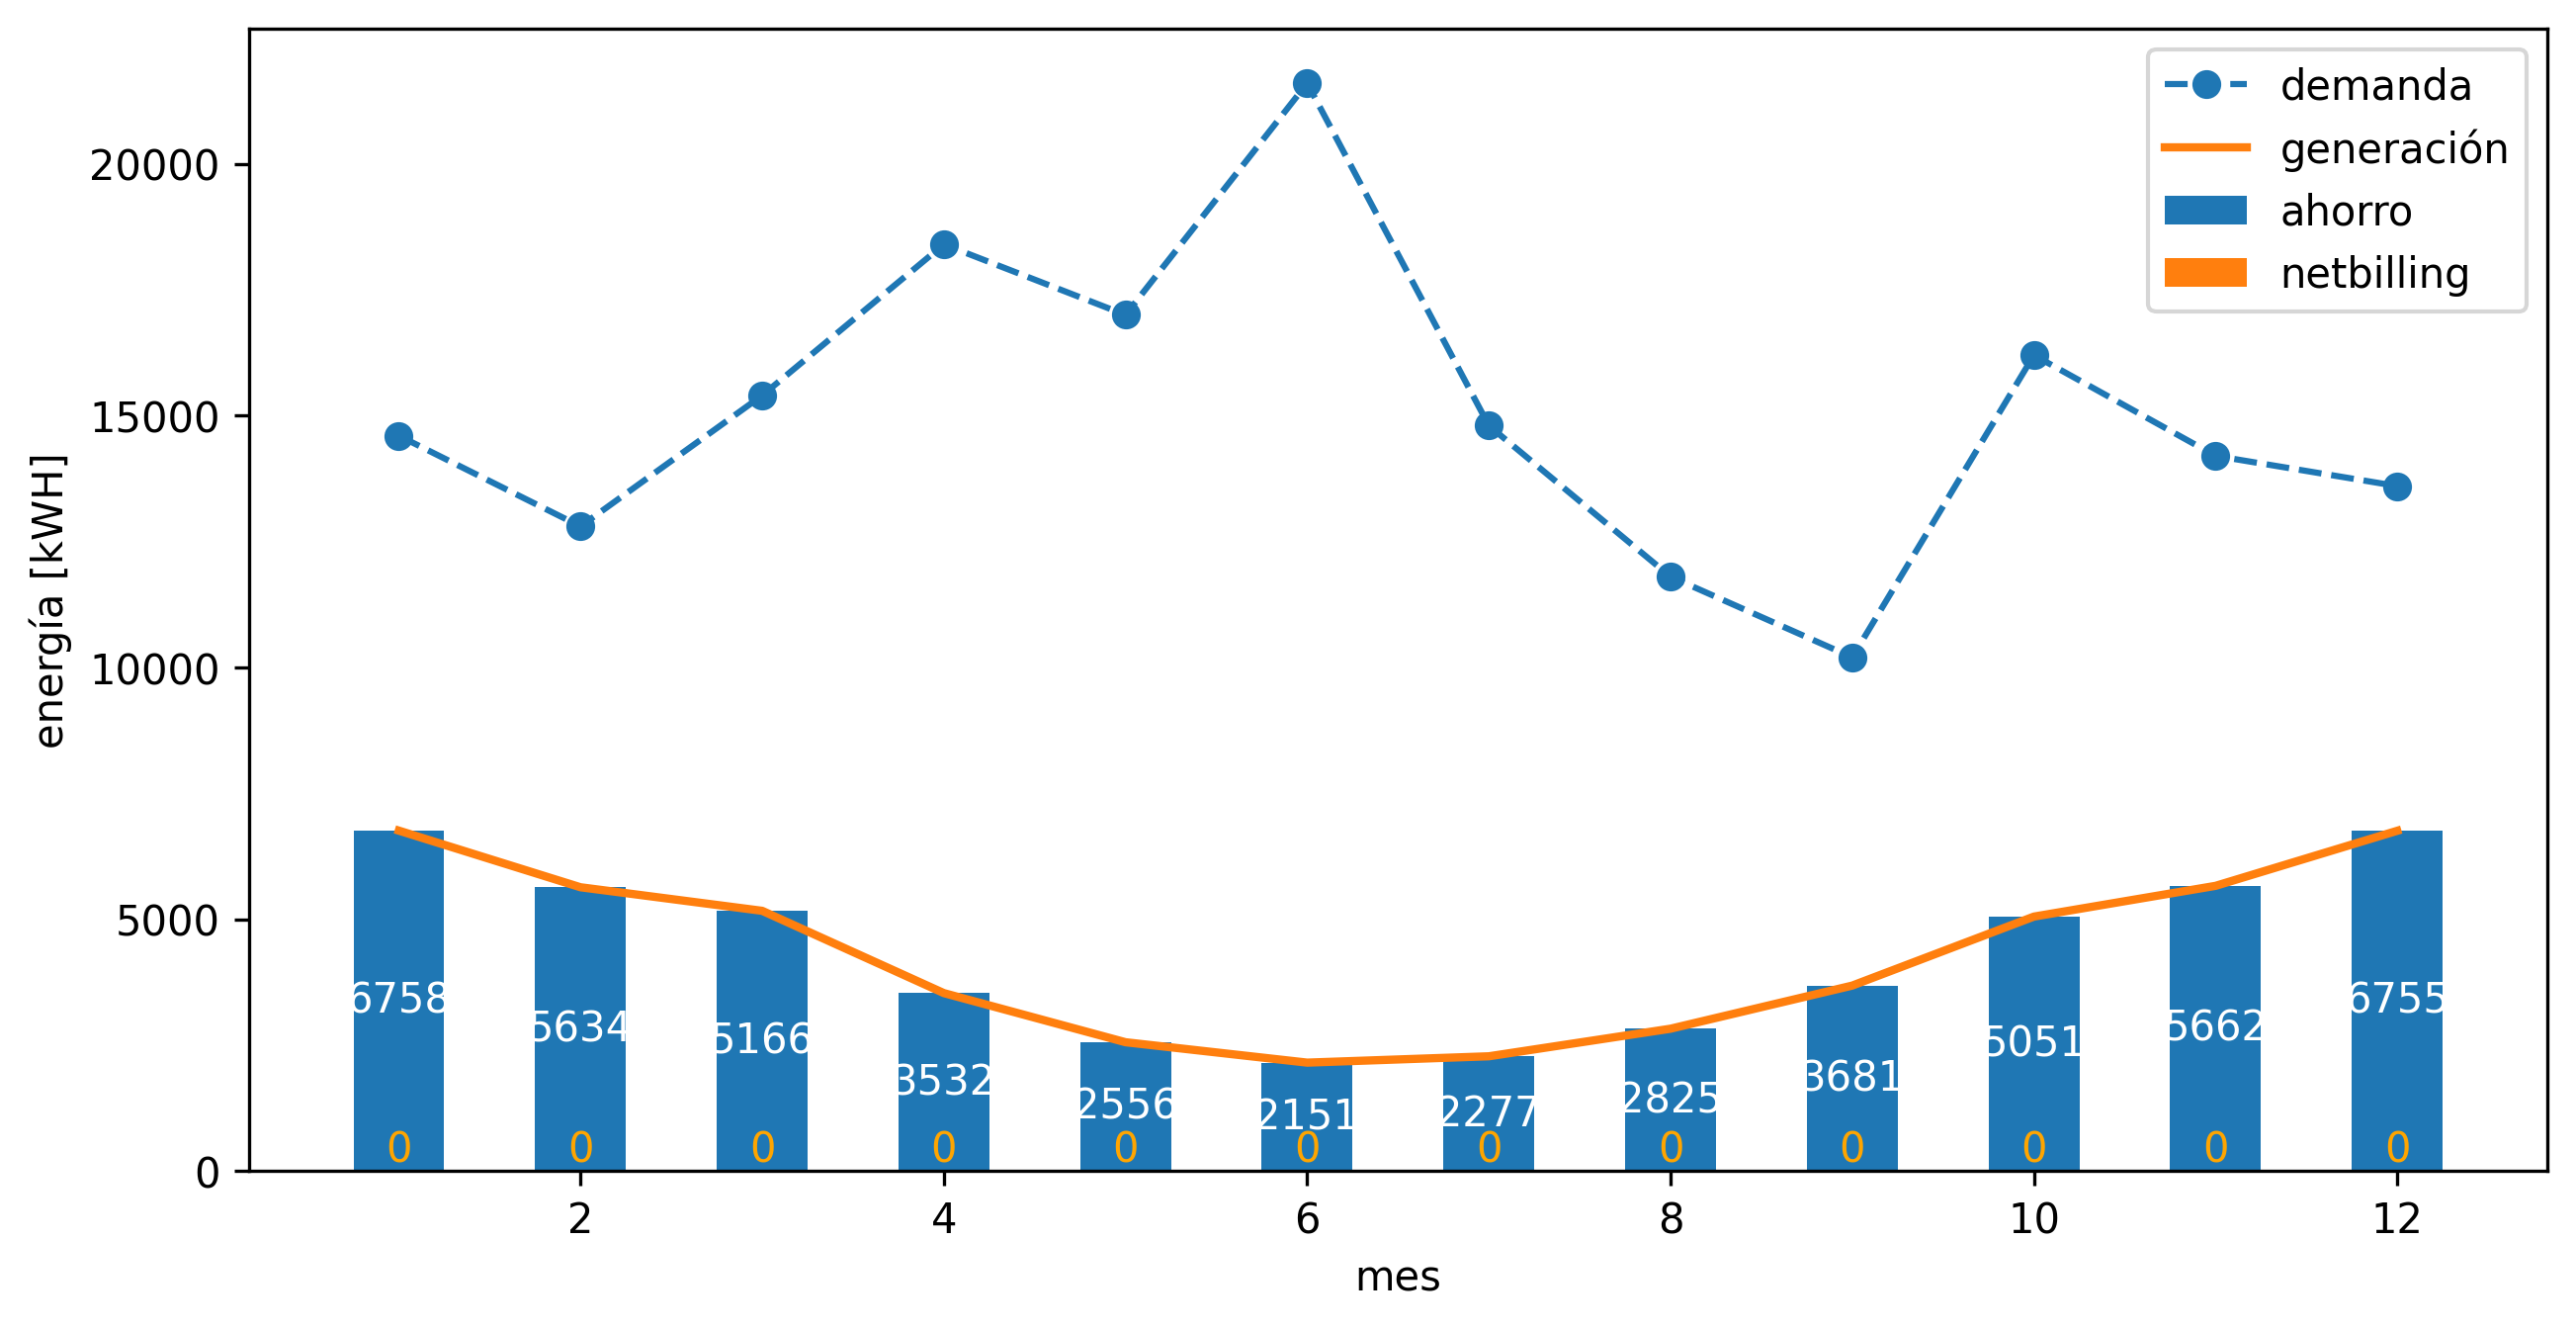

<Figure size 1920x1440 with 0 Axes>

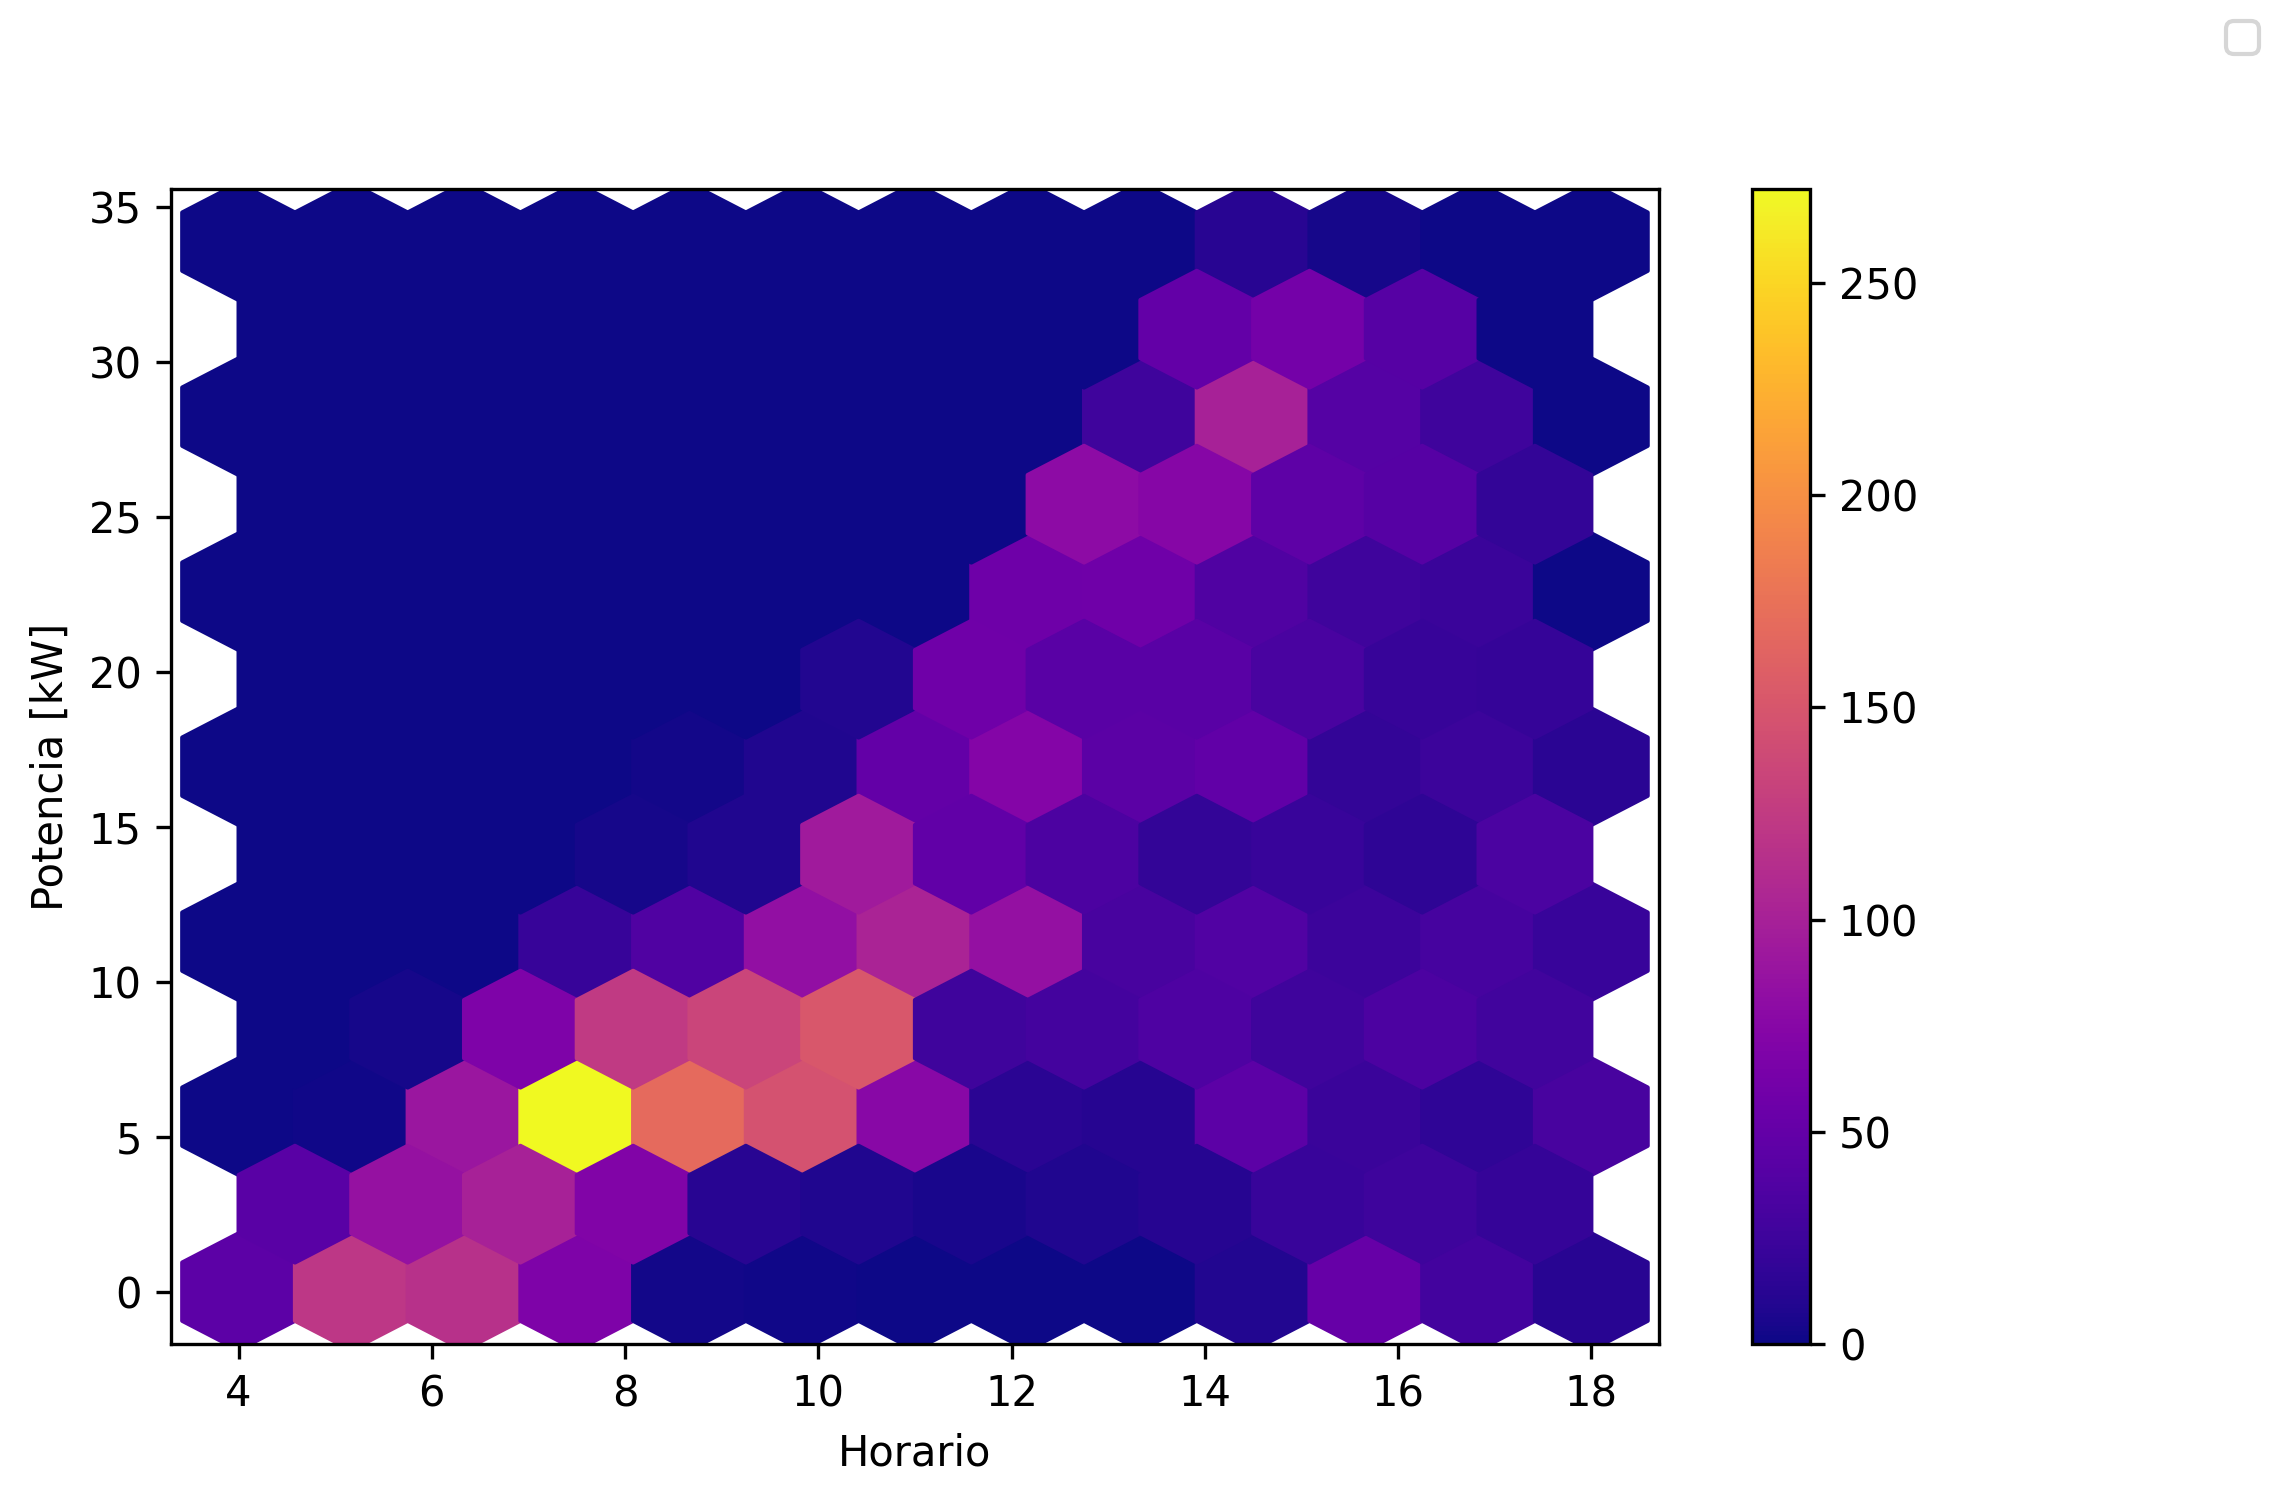

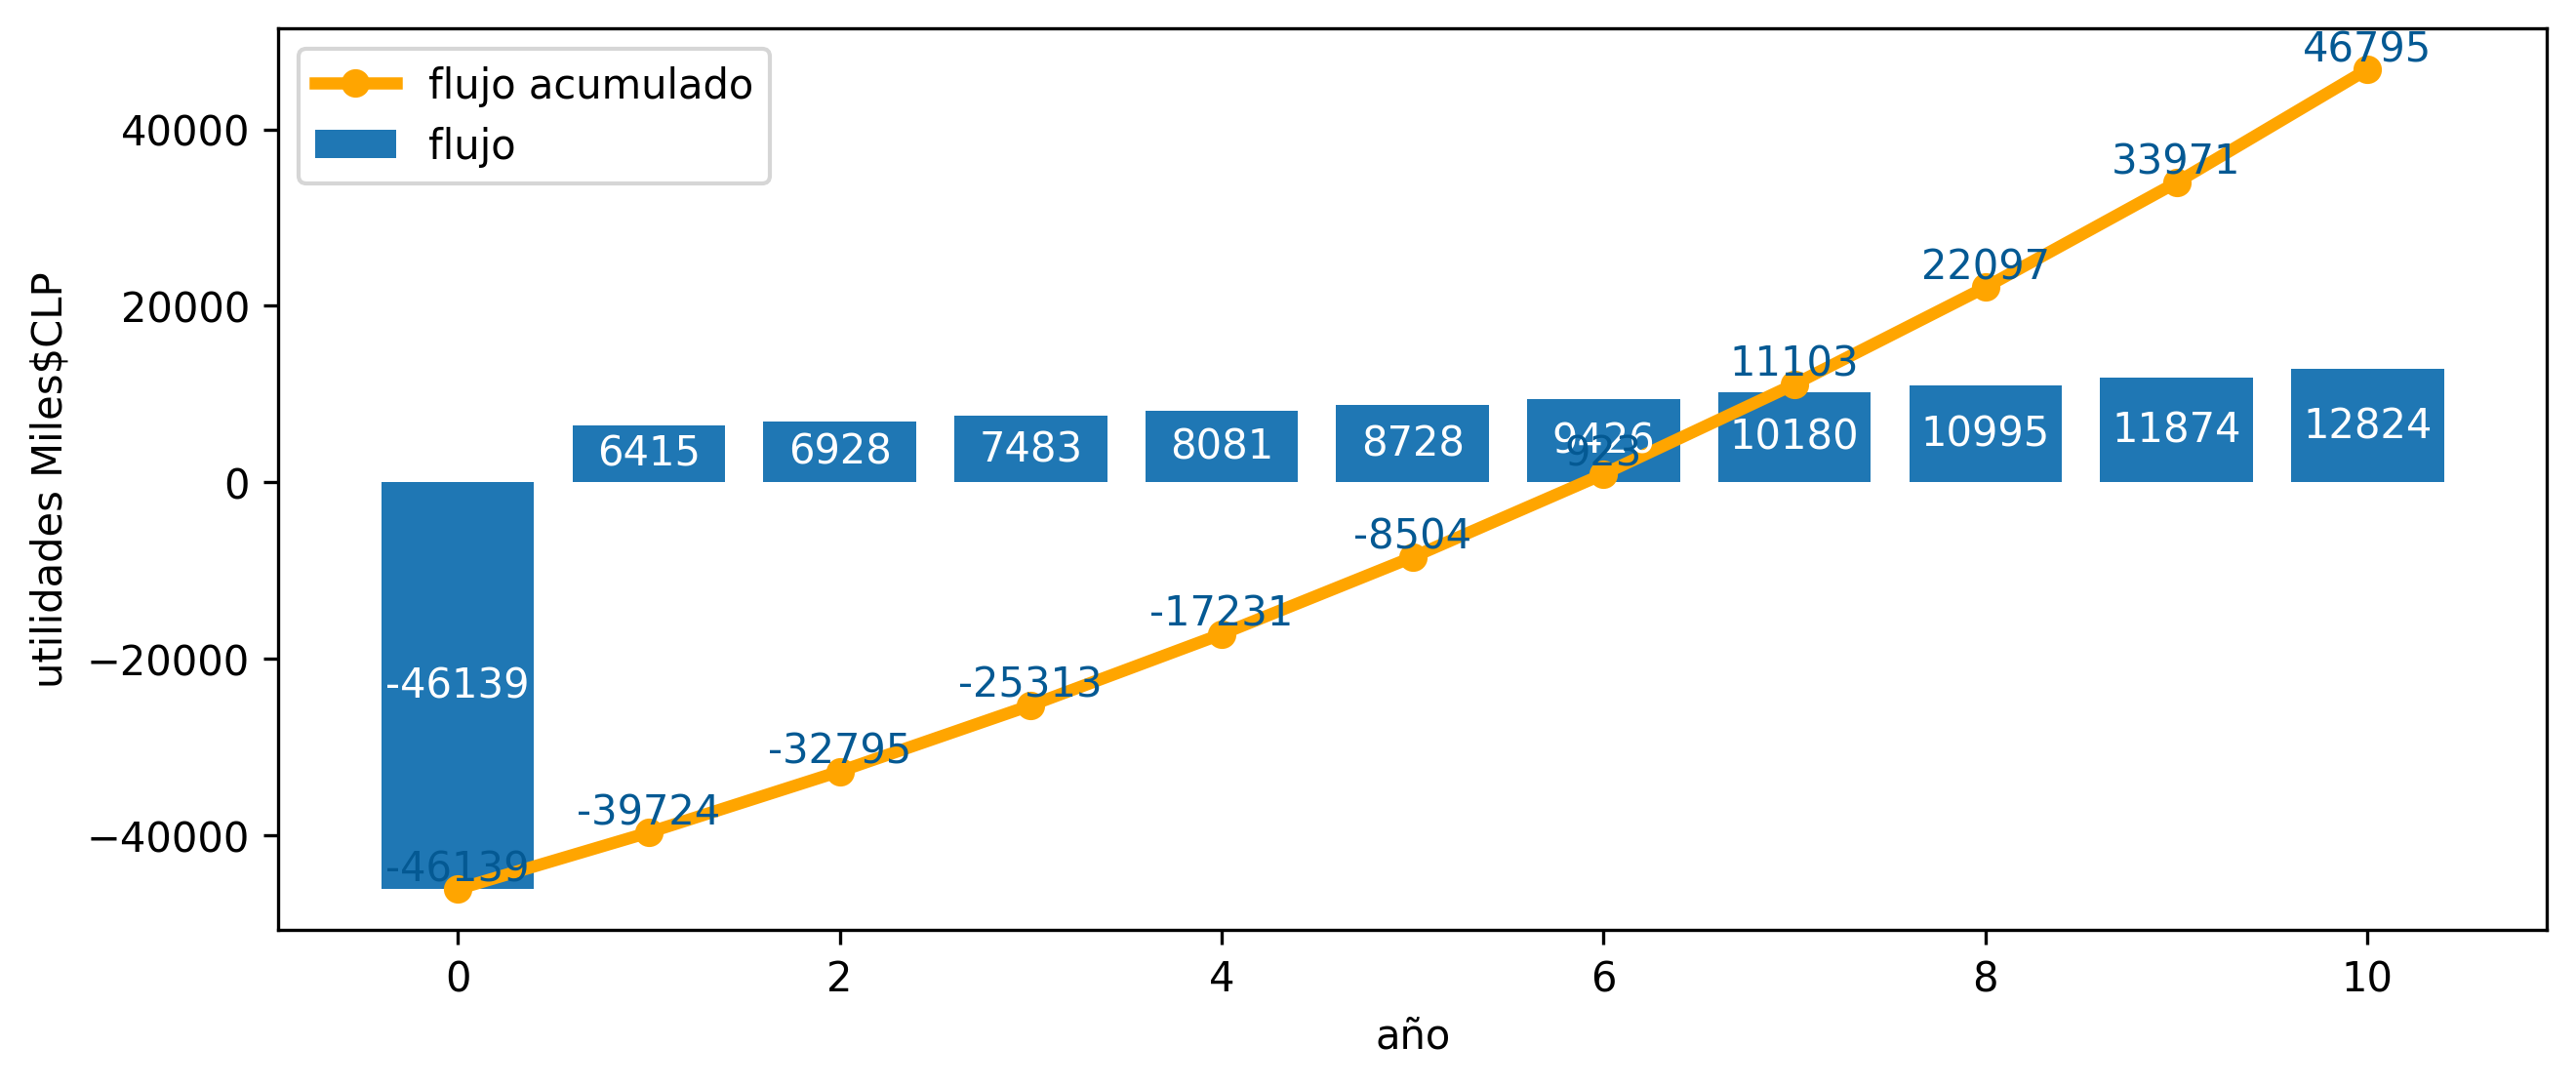

In [11]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [12]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
    'map_location'
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux
replaced plot: map_location


In [13]:
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")